In [1]:
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS 
import seaborn as sns
import torch
from torch import tensor

# Problem 2: Reed Frogs

The common reed frog is a species of frogs found naturally in many parts of Africa. 

In this assignment, we check, evaluate and compare three models which rely on tank density, frog size and predation to predict frog survivability. ![common Reed Frog](https://upload.wikimedia.org/wikipedia/commons/3/36/Tree_frog_congo.jpg)	


In [2]:
df = pd.read_csv('input/04reedfrogs.csv')


In [3]:
# categorize values
df["cdensity"] = pd.factorize(df.density)[0]
df["cpred"] = pd.factorize(df.pred)[0]
df["csize"] = pd.factorize(df["size"])[0]
df.head(10)

,density,pred,size,surv,propsurv,cdensity,cpred,csize
0,10,no,big,9,0.9,0,0,0
1,10,no,big,10,1.0,0,0,0
2,10,no,big,7,0.7,0,0,0
3,10,no,big,10,1.0,0,0,0
4,10,no,small,9,0.9,0,0,1
5,10,no,small,9,0.9,0,0,1
6,10,no,small,10,1.0,0,0,1
7,10,no,small,9,0.9,0,0,1
8,10,pred,big,4,0.4,0,1,0
9,10,pred,big,9,0.9,0,1,0


## Effect of Predation
It is easily visible that predation has a large effect on the frogs' survivability:

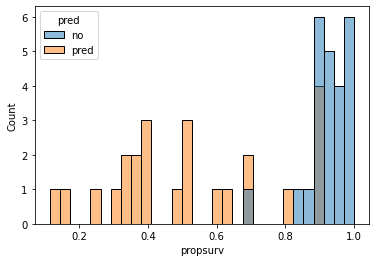

In [4]:
sns.histplot(data=df, x="propsurv", hue="pred", bins=30);

## Defining the Models
`reedfrogs_lin` is the generalized linear regression model. `reedfrogs_hier5` is the hierarchical model from lecture 5 based on population only. `reedfrogs_hier6` is the hierarchical model from lecture 6 based on population size and predation.

In [6]:
def reedfrogs_hier5(density, survival):
    N = len(density)
    sigma = pyro.sample("sigma", dist.Exponential(tensor([1.])))
    alpha_0 = pyro.sample("alpha_0", dist.Normal(tensor([0.]), tensor([1.5])))
    alpha_t = pyro.sample("alpha_t", dist.MultivariateNormal(torch.full([N], alpha_0.item()), sigma.item() * torch.eye(N)))
    for i in range(len(density)):
        alpha = alpha_t[i]
        p = torch.sigmoid(alpha)
        pyro.sample(f"survival_{i}", dist.Binomial(density[i], p), obs=tensor(survival[i]))

In [ ]:
# todo: why is this so slow?
nuts_kernel = NUTS(reedfrogs_hier5, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(df.density, df.surv)
mcmc.get_samples()